In [3]:
%matplotlib inline
%load_ext autoreload
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
from kam11 import context, matchedFilter, thermister, rayModeling
from beamforming import curvedWaveFront, timeDomain
from atpy import bellhop, arrivals
from kam11.plotting import mfPlotting
import matplotlib.pyplot as plt
import scipy.signal as sig
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
timeOfInterest='2011 J184 03:51:15'
loadDuration=dt.timedelta(0,5)
thetaRange=(-8,8)
numTheta=1000
beamformingStart=-6
beamformingEnd=3
numBeams=1000
#Choose a single snapshot index for beamforming
snapshotIndex=10
upRate = 5

#Model simulation
bellhopFilesDir='/Users/edwardlrichards/cir_processing/bellhopFiles/beamforming'

#figure saving
figSaveDir='/Users/edwardlrichards/cir_processing/beamforming_072915'


In [5]:
tof = dt.datetime.strptime(timeOfInterest, '%Y J%j %H:%M:%S')
cirEstimate=matchedFilter.LFM_MatchedFilter(tof,\
                                           loadDuration=loadDuration)
ssp=thermister.getSoundSpeed(tof)
rd=context.VLA1().phoneDepths()

In [6]:
mf=cirEstimate.matchedFilter()

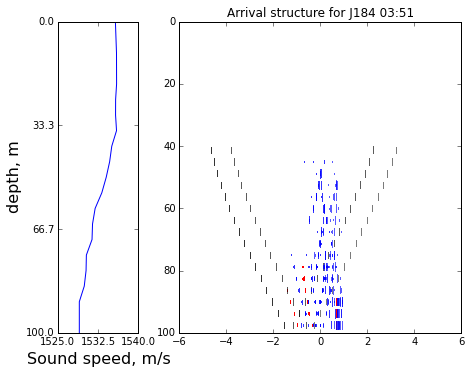

In [7]:
#plot bellhop prediction
%autoreload
arrivals=rayModeling.getBellhopArrivals(tof,\
                            bellhopFilesDir=bellhopFilesDir)
arrivals.ref0dB()
title='Arrival structure for %s'%tof.strftime('J%j %H:%M')
figName=tof.strftime('J%j_%H_%M_Arrivals')
fig=bellhop.plotArrivalSpark(title, ssp, arrivals,\
    figDir=figSaveDir, figName=figName)

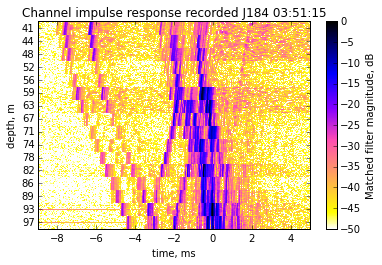

In [9]:
fig=mfPlotting.plotMultipleChannel(mf,vmin=-50,\
                                        tStart=-9, tEnd=5, norm='total')
savename='mf_%s'%tof.strftime('J%j_%H_%M')
# fig.savefig(os.path.join(figSaveDir,savename))

In [10]:
fastTime=mf[mf['channelNames'][0]].index
def getSingleSnap():
    for m in mf['channelNames']:
        yield(mf[m].iloc[:,snapshotIndex])
lookData=pd.DataFrame(list(getSingleSnap()),\
        index=mf['channelNames'],columns=fastTime).T

TypeError: 'MatchedFilter' object is not subscriptable

In [ ]:
thetaTest=np.r_[thetaRange[0]:thetaRange[1]:1j*numTheta]
testDelay=curvedWaveFront.getDelays(thetaTest, ssp, rd, rd[1])

centerTime=np.r_[beamformingStart:beamformingEnd:1j*numBeams]
centerTime /= 1e3

In [ ]:
#Bellhop beamforming
# Create synthetic data set
winStart=beamformingStart/1e3+np.nanmin(np.array(testDelay))
winEnd=beamformingEnd/1e3+np.nanmax(np.array(testDelay))

simData=arrivals.sampleArrivals(context.fs,(winStart,winEnd))

In [ ]:
#Bellhop beamforming
beamB=timeDomain.timeBeamformer(simData, centerTime,
                                testDelay, upsample=upRate)

In [ ]:
testDelay.shape

In [ ]:
lookDB=20*np.log10(np.abs(np.array(beamB))+np.spacing(1))
lookDB-=np.max(lookDB)
X,Y=np.meshgrid(1e3*centerTime,thetaTest)
fig,ax=plt.subplots()
pc=ax.pcolormesh(X,Y,lookDB.T,vmin=-30,vmax=0,cmap=plt.cm.gnuplot2_r)
cb=fig.colorbar(pc)
# _=cb.set_ticks([-40,-30-20,-10,0])
# _=ax.set_xlim(beamformingStart,beamformingEnd)
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
ax.xaxis.set_major_formatter(x_formatter)
_=ax.set_xlabel('time delay, ms')
_=ax.set_ylabel('look direction, degrees')
_=ax.set_title('Beamforming result for bellhop predictions\n'+\
              '%s'%tof.strftime('J%j %H:%M UTC'))

savename='bellBeams_%s'%tof.strftime('J%j_%H_%M')
fig.savefig(os.path.join(figSaveDir,savename))
# plt.savefig('/Users/edwardlrichards/ipythonNotebooks/KAM 11 enviornment/curvedWaveFronts/figures/arrivals')

In [ ]:
#Data beamforming
beamD=timeDomain.timeBeamformer(lookData, centerTime,
                                testDelay, upsample=upRate)

In [ ]:
lookDB=20*np.log10(np.abs(np.array(beamD))+np.spacing(1))
lookDB-=np.max(lookDB)
X,Y=np.meshgrid(1e3*centerTime,thetaTest)
fig,ax=plt.subplots()
pc=ax.pcolormesh(X,Y,lookDB.T,vmin=-30,vmax=0,cmap=plt.cm.gnuplot2_r)
cb=fig.colorbar(pc)
# _=cb.set_ticks([-40,-30-20,-10,0])
# _=ax.set_xlim(beamformingStart,beamformingEnd)
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
ax.xaxis.set_major_formatter(x_formatter)
_=ax.set_xlabel('time delay, ms')
_=ax.set_ylabel('look direction, degrees')
_=ax.set_title('Beamforming result for match filter \n'+\
              '%s'%tof.strftime('J%j %H:%M UTC'))
savename='mfBeams_%s'%tof.strftime('J%j_%H_%M')
fig.savefig(os.path.join(figSaveDir,savename))
# plt.savefig('/Users/edwardlrichards/ipythonNotebooks/KAM 11 enviornment/curvedWaveFronts/figures/arrivals')